# Transformer for Source Code

## Load Vocab from File

In [10]:
import torch
from generator import Generator
from models.trav_trans.dataset import Vocab

vocab = Vocab("output/vocab.pkl")

INFO:root:Loaded vocab from: output/vocab.pkl
INFO:root:Vocab size: 100002


## Load Model from File

In [11]:
import model
model = model.from_file("output/transformer4code-final.pt", vocab)
m = model.eval()

## Plot Loss

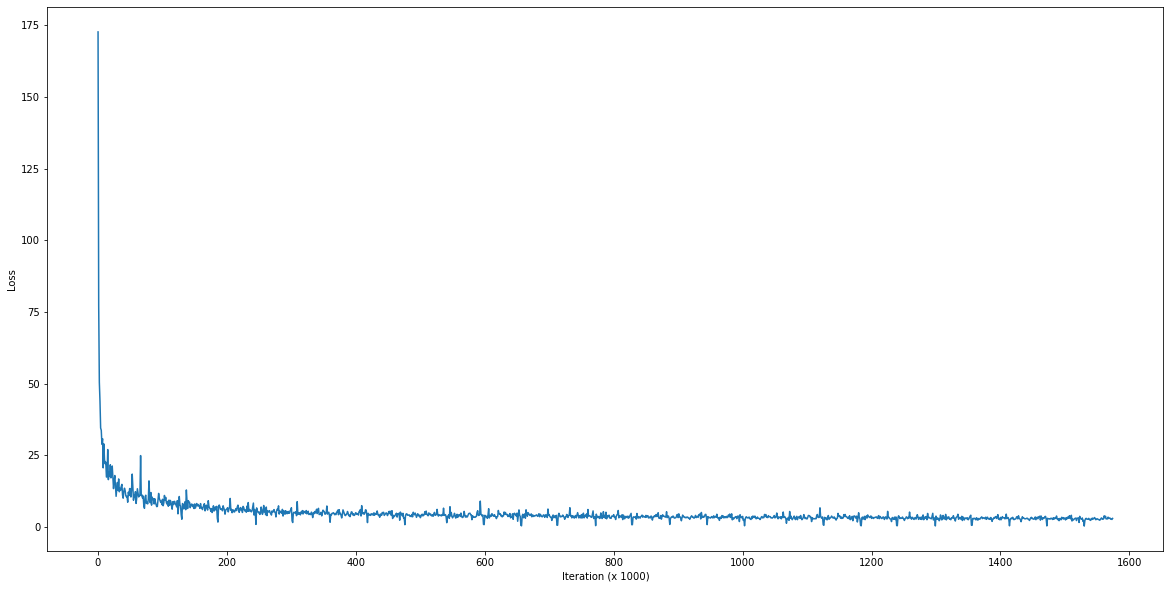

In [14]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pickle

with open("output/losses.pickle", "rb") as fin:
    losses = pickle.load(fin)
l = [loss[2] for loss in losses]
figure(figsize=(20, 10))
plt.xlabel("Iteration (x 1000)")
plt.ylabel("Loss")
plt.plot(range(len(losses)), l)

In [6]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
# count_parameters(model)

## Generate Tokens

In [1]:
from ipywidgets import interact, widgets
from IPython.display import display

textarea = widgets.Textarea(
    value="a = [1, 2, 3, 4, 5]\nprint(len(a))",
    placeholder='Type something',
    description='Python Code',
    disabled=False,
    layout=widgets.Layout(width="100%", height="300px")
)
display(textarea)

Textarea(value='a = [1, 2, 3, 4, 5]\nprint(len(a))', description='Python Code', layout=Layout(height='300px', …

In [300]:
import code_parser, generate_new_trees, json, utils
ast_raw = code_parser.parse_code(textarea.value)
ast = json.dumps(generate_new_trees.convert(json.loads(ast_raw)))
ast_original = ast
# Remove last 2 nodes
ast = json.dumps(json.loads(ast)[:-2])

Complete tree


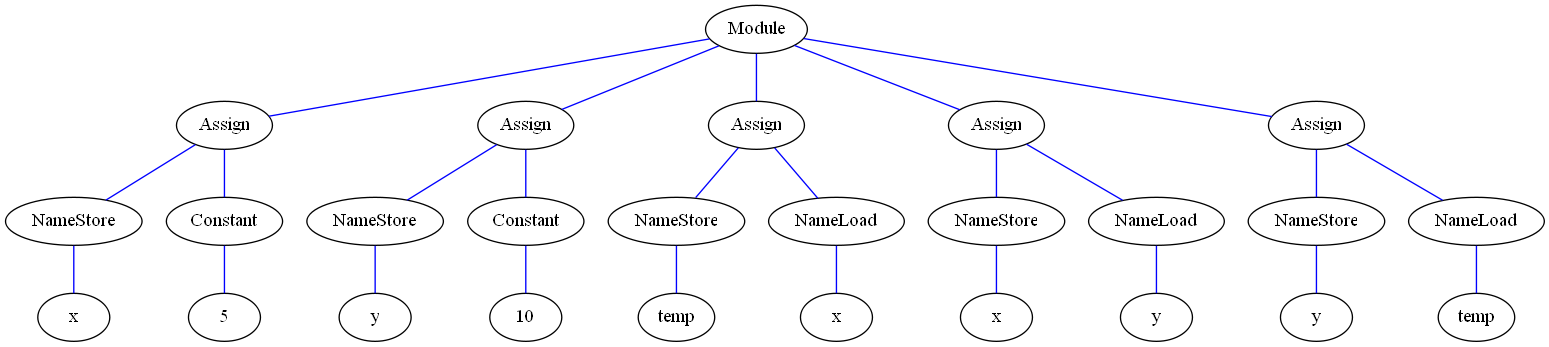

In [301]:
from IPython.display import Image
import generate_graph

print("Complete tree")
outfile = "outfile_original.png"
generate_graph.visualize(ast_original, outfile)
Image(outfile)

Remove last two nodes


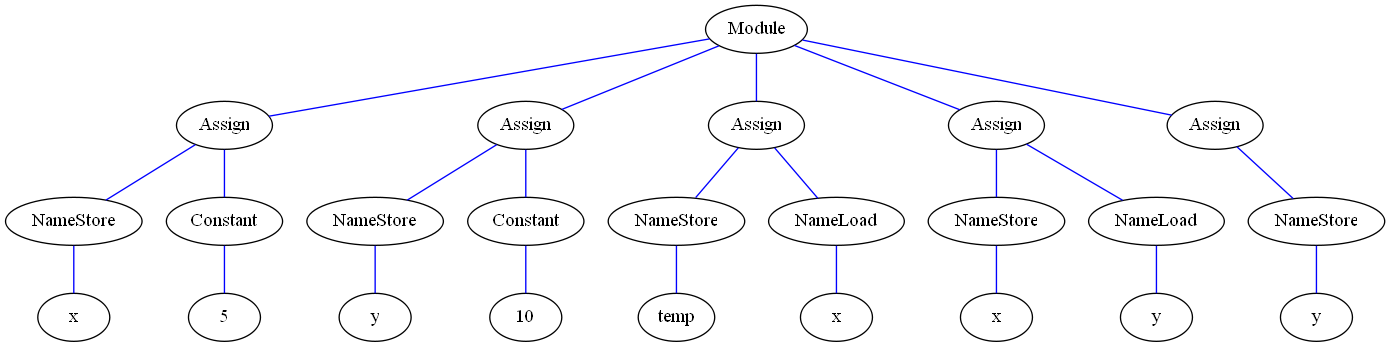

In [302]:
print("Remove last two nodes")
outfile = "outfile.png"
generate_graph.visualize(ast, outfile)
Image(outfile)

In [2]:
import torch.nn.functional as F

def output_probabilities(idx, iterations):
    input = idx
    for i in range(iterations):
        with torch.no_grad():
            output = model(torch.tensor(input), None)
        logits = output[-1]
        softmax = F.softmax(logits, dim=-1)
        top_k_values, top_k_indices = torch.topk(softmax, 5)
        for e, v in enumerate(top_k_values):
            print("Prediction {}: {}({})".format(i, vocab.idx2vocab[top_k_indices[e]], round(float(v), 2)))
        input.append(top_k_indices[0].item())
    return input

In [152]:
def generate(model, context, num_beams=2, depth=3):
    generated = [[[]] * (num_beams ** (d + 1)) for d in range(depth)]    
    return generated

generate(model, [vocab.vocab2idx["Module"]])
            

[[[], []], [[], [], [], []], [[], [], [], [], [], [], [], []]]

In [304]:
num_gen = 2

nodes = utils.get_dfs(json.loads(ast))
idx = vocab.convert([nodes, 0])[0]
print([vocab.idx2vocab[n] for n in idx])
prediction = output_probabilities(idx, num_gen)
print("Prediction: {}".format([vocab.idx2vocab[n] for n in prediction[-num_gen:]]))



['Module', 'Assign', 'NameStore', 'x', 'Constant', '5', 'Assign', 'NameStore', 'y', 'Constant', '10', 'Assign', 'NameStore', 'temp', 'NameLoad', 'x', 'Assign', 'NameStore', 'x', 'NameLoad', 'y', 'Assign', 'NameStore', 'y']
Prediction 0: Assign(0.37)
Prediction 0: Call(0.35)
Prediction 0: NameLoad(0.07)
Prediction 0: y(0.04)
Prediction 0: Str(0.02)
Prediction 1: NameStore(1.0)
Prediction 1: TupleStore(0.0)
Prediction 1: AttributeStore(0.0)
Prediction 1: SubscriptStore(0.0)
Prediction 1: Assign(0.0)
Prediction: ['Assign', 'NameStore']
